# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-phi.new.339.357.359.362.366.367.382.383.389.408.fix.360.373.406'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

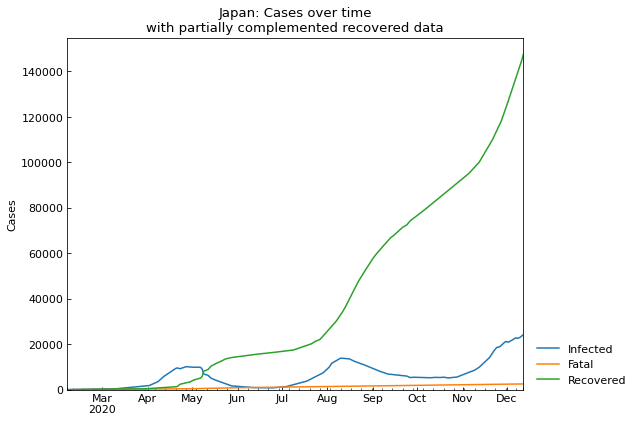

,Date,Confirmed,Infected,Fatal,Recovered
306,2020-12-08,163929,22553,2382,138994
307,2020-12-09,165840,22798,2420,140622
308,2020-12-10,168573,23102,2465,143006
309,2020-12-11,171542,24026,2502,145014
310,2020-12-12,174299,24241,2534,147524


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of new cases with `Scenario.record_diff()` method.

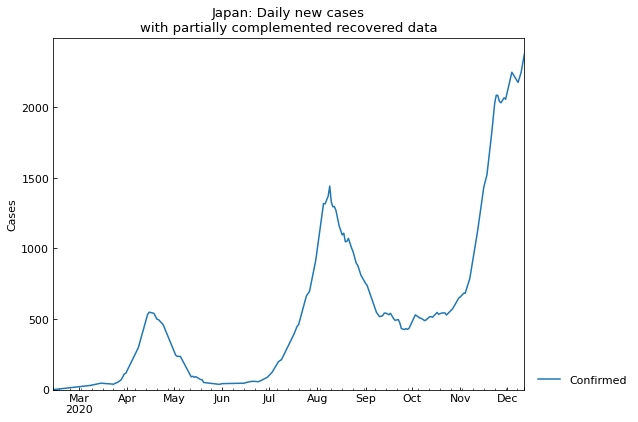

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

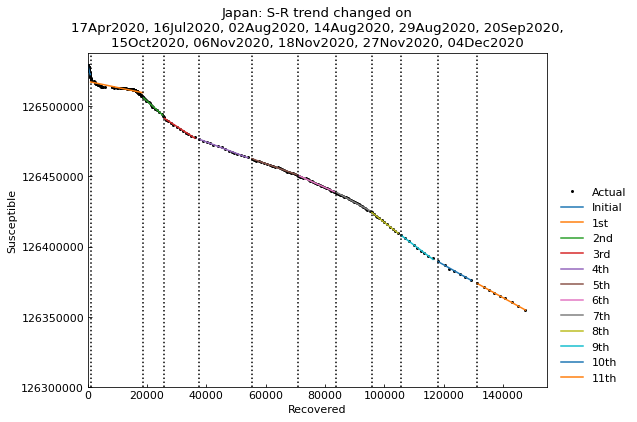

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,15Jul2020,126529100
2nd,Past,16Jul2020,01Aug2020,126529100
3rd,Past,02Aug2020,13Aug2020,126529100
4th,Past,14Aug2020,28Aug2020,126529100
5th,Past,29Aug2020,19Sep2020,126529100
6th,Past,20Sep2020,14Oct2020,126529100
7th,Past,15Oct2020,05Nov2020,126529100
8th,Past,06Nov2020,17Nov2020,126529100
9th,Past,18Nov2020,26Nov2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 2nd phase (27Nov2020 - 03Dec2020): finished  313 trials in 0 min 10 sec


	10th phase (02Aug2020 - 13Aug2020): finished 3174 trials in 3 min  0 sec

	 0th phase (17Apr2020 - 15Jul2020): finished 3075 trials in 3 min  0 sec

	 9th phase (06Feb2020 - 16Apr2020): finished 3099 trials in 3 min  0 sec

	 7th phase (16Jul2020 - 01Aug2020): finished 3208 trials in 3 min  0 sec

	11th phase (29Aug2020 - 19Sep2020): finished  210 trials in 0 min 10 sec

	 4th phase (06Nov2020 - 17Nov2020): finished  611 trials in 0 min 30 sec

	 8th phase (04Dec2020 - 12Dec2020): finished 1704 trials in 1 min 40 sec

	 5th phase (14Aug2020 - 28Aug2020): finished 1134 trials in 1 min  0 sec

	 3rd phase (15Oct2020 - 05Nov2020): finished 2678 trials in 3 min  0 sec

	 1st phase (18Nov2020 - 26Nov2020): finished 2799 trials in 3 min  0 sec

	 6th phase (20Sep2020 - 14Oct2020): finished 2873 trials in 3 min  1 sec

Completed optimization. Total: 6 min 42 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/alpha2 [day],alpha1 [-],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.62,0.018973,0.000151,0.020557,0.004215,288,47,1324,0.019,9,0.259382,3099,3 min 0 sec
1st,Past,17Apr2020,15Jul2020,126529100,SIR-F,0.53,0.045027,0.000366,0.006130,0.010719,288,18,546,0.045,32,0.354283,3075,3 min 0 sec
2nd,Past,16Jul2020,01Aug2020,126529100,SIR-F,2.03,0.000019,0.000041,0.027674,0.013565,288,14,4908,0.000,7,0.025835,3208,3 min 0 sec
3rd,Past,02Aug2020,13Aug2020,126529100,SIR-F,1.63,0.000381,0.000052,0.021052,0.012852,288,15,3856,0.000,9,0.040035,3174,3 min 0 sec
4th,Past,14Aug2020,28Aug2020,126529100,SIR-F,0.83,0.000896,0.000156,0.016886,0.020085,288,9,1281,0.001,11,0.015634,1134,1 min 0 sec
5th,Past,29Aug2020,19Sep2020,126529100,SIR-F,0.70,0.020028,0.000002,0.015539,0.021615,288,9,107736,0.020,12,0.059091,210,0 min 10 sec
6th,Past,20Sep2020,14Oct2020,126529100,SIR-F,0.92,0.000614,0.000192,0.017143,0.018375,288,10,1039,0.001,11,0.024500,2873,3 min 1 sec
7th,Past,15Oct2020,05Nov2020,126529100,SIR-F,1.11,0.002317,0.000181,0.020578,0.018365,288,10,1103,0.002,9,0.028790,2678,3 min 0 sec
8th,Past,06Nov2020,17Nov2020,126529100,SIR-F,1.62,0.000590,0.000114,0.028042,0.017200,288,11,1758,0.001,7,0.009464,611,0 min 30 sec
9th,Past,18Nov2020,26Nov2020,126529100,SIR-F,1.63,0.000529,0.000148,0.027339,0.016587,288,12,1354,0.001,7,0.020375,2799,3 min 0 sec


### Accuracy of estimation

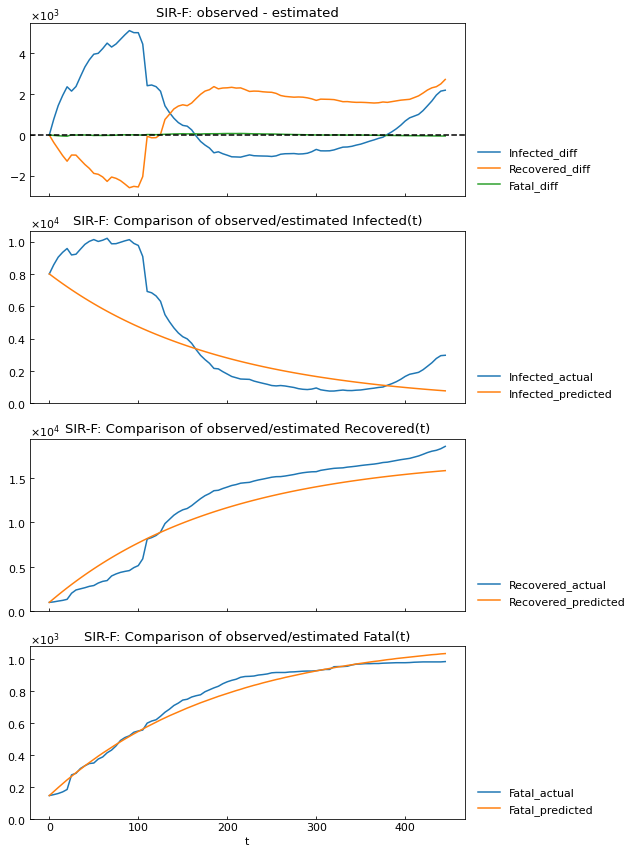

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [12]:
snl.get("Rt", phase="4th")

0.83

### Show parameter history

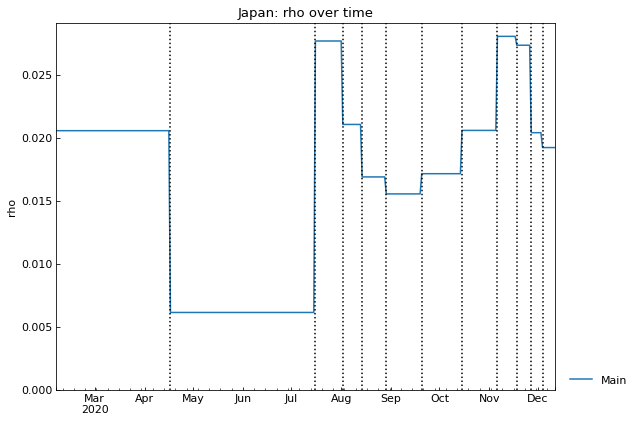

In [13]:
_ = snl.history(target="rho")

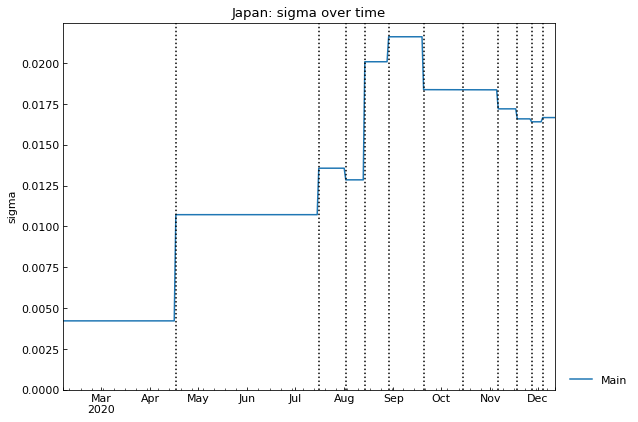

In [14]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

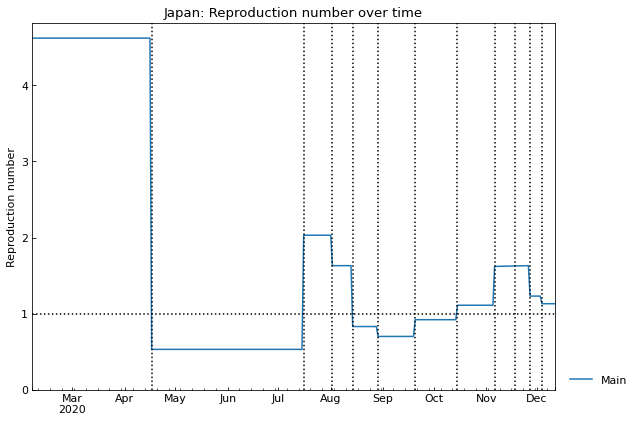

In [15]:
_ = snl.history(target="Rt")

### Simulate the number of cases

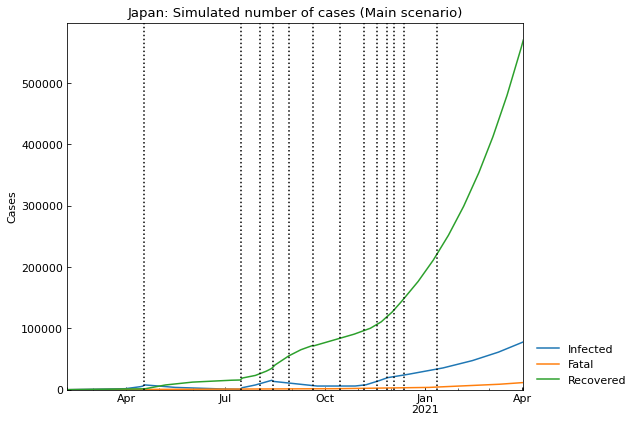

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,630253,11082,74739,544432
418,2021-03-30,637436,11216,75527,550693
419,2021-03-31,644693,11351,76323,557019
420,2021-04-01,652028,11488,77127,563413
421,2021-04-02,659438,11626,77939,569873


In [16]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [17]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.016665632953380558

In [18]:
sigma_new = sigma_current * 2
sigma_new

0.033331265906761116

In [19]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  4.62   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.53   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  2.03   
         3rd      Past  02Aug2020  13Aug2020   126529100  SIR-F  1.63   
         4th      Past  14Aug2020  28Aug2020   126529100  SIR-F  0.83   
         5th      Past  29Aug2020  19Sep2020   126529100  SIR-F  0.70   
         6th      Past  20Sep2020  14Oct2020   126529100  SIR-F  0.92   
         7th      Past  15Oct2020  05Nov2020   126529100  SIR-F  1.11   
         8th      Past  06Nov2020  17Nov2020   126529100  SIR-F  1.62   
         9th      Past  18Nov2020  26Nov2020   126529100  SIR-F  1.63   
         10th     Past  27Nov2020  03Dec2020   126529100  SIR-F  1.23   
         11th     Past  04Dec2020  12Dec2020   126529100  SIR-F  1.13   
         12th   Future  13Dec2020  11Jan2021   126529100  SIR-F  1.13   
         13th   Future  12Jan2021  01Apr2021   126529100  SIR-F  1.13   
Medicine 0th      Past  06Feb2020  16Apr2020   126529100  SIR-F  4.62   
         1st      Past  17Apr2020  15Jul2020   126529100  SIR-F  0.53   
         2nd      Past  16Jul2020  01Aug2020   126529100  SIR-F  2.03   
         3rd      Past  02Aug2020  13Aug2020   126529100  SIR-F  1.63   
         4th      Past  14Aug2020  28Aug2020   126529100  SIR-F  0.83   
         5th      Past  29Aug2020  19Sep2020   126529100  SIR-F  0.70   
         6th      Past  20Sep2020  14Oct2020   126529100  SIR-F  0.92   
         7th      Past  15Oct2020  05Nov2020   126529100  SIR-F  1.11   
         8th      Past  06Nov2020  17Nov2020   126529100  SIR-F  1.62   
         9th      Past  18Nov2020  26Nov2020   126529100  SIR-F  1.63   
         10th     Past  27Nov2020  03Dec2020   126529100  SIR-F  1.23   
         11th     Past  04Dec2020  12Dec2020   126529100  SIR-F  1.13   
         12th   Future  13Dec2020  11Jan2021   126529100  SIR-F  1.13   
         13th   Future  12Jan2021  01Apr2021   126529100  SIR-F  0.57   

                   theta     kappa       rho     sigma  tau  1/gamma [day]  \
Scenario Phase                                                               
Main     0th    0.018973  0.000151  0.020557  0.004215  288             47   
         1st    0.045027  0.000366  0.006130  0.010719  288             18   
         2nd    0.000019  0.000041  0.027674  0.013565  288             14   
         3rd    0.000381  0.000052  0.021052  0.012852  288             15   
         4th    0.000896  0.000156  0.016886  0.020085  288              9   
         5th    0.020028  0.000002  0.015539  0.021615  288              9   
         6th    0.000614  0.000192  0.017143  0.018375  288             10   
         7th    0.002317  0.000181  0.020578  0.018365  288             10   
         8th    0.000590  0.000114  0.028042  0.017200  288             11   
         9th    0.000529  0.000148  0.027339  0.016587  288             12   
         10th   0.003250  0.000164  0.020397  0.016407  288             12   
         11th   0.000736  0.000342  0.019216  0.016666  288             12   
         12th   0.000736  0.000342  0.019216  0.016666  288             12   
         13th   0.000736  0.000342  0.019216  0.016666  288             12   
Medicine 0th    0.018973  0.000151  0.020557  0.004215  288             47   
         1st    0.045027  0.000366  0.006130  0.010719  288             18   
         2nd    0.000019  0.000041  0.027674  0.013565  288             14   
         3rd    0.000381  0.000052  0.021052  0.012852  288             15   
         4th    0.000896  0.000156  0.016886  0.020085  288              9   
         5th    0.020028  0.000002  0.015539  0.021615  288              9   
         6th    0.000614  0.000192  0.017143  0.018375  288             10   
         7th    0.002317  0.00018

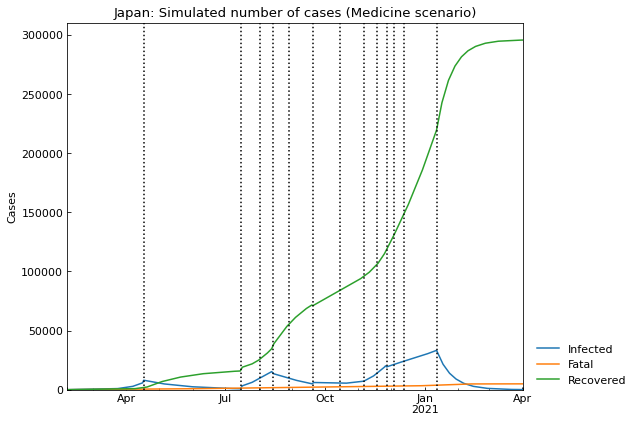

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,300552,4942,135,295475
418,2021-03-30,300563,4942,125,295496
419,2021-03-31,300574,4942,116,295516
420,2021-04-01,300586,4943,108,295535
421,2021-04-02,300596,4943,101,295552


In [20]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [21]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,13th_Rt
Main,77939,02Apr2021,659438,77939,11626,1.13
Medicine,33264,12Jan2021,300596,101,4943,0.57


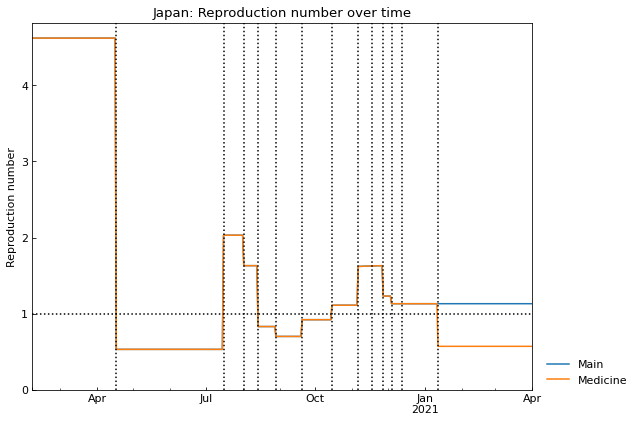

In [22]:
_ = snl.history(target="Rt")

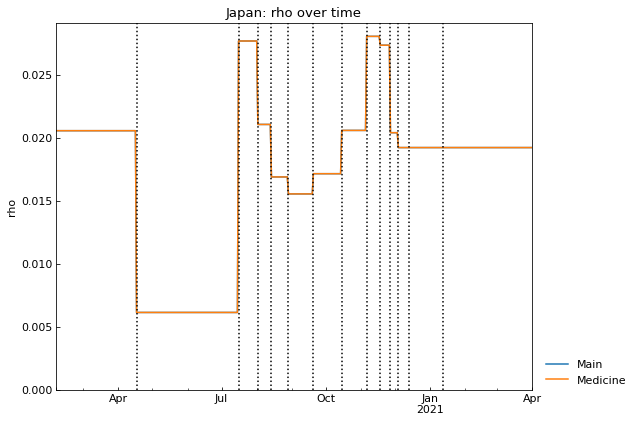

In [23]:
_ = snl.history(target="rho")

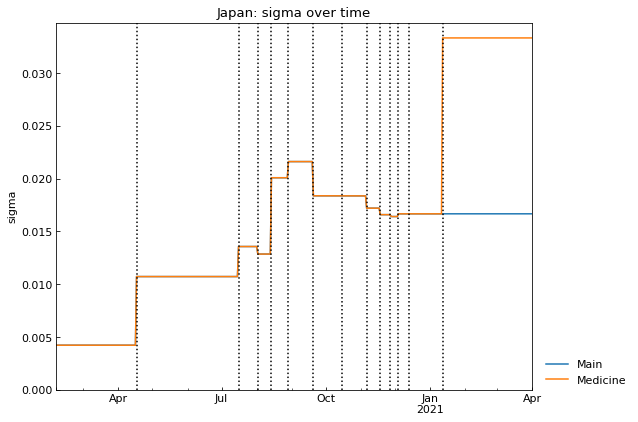

In [24]:
_ = snl.history(target="sigma")

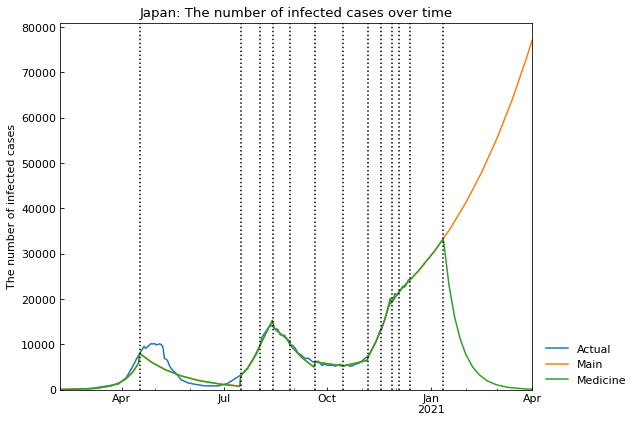

In [25]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

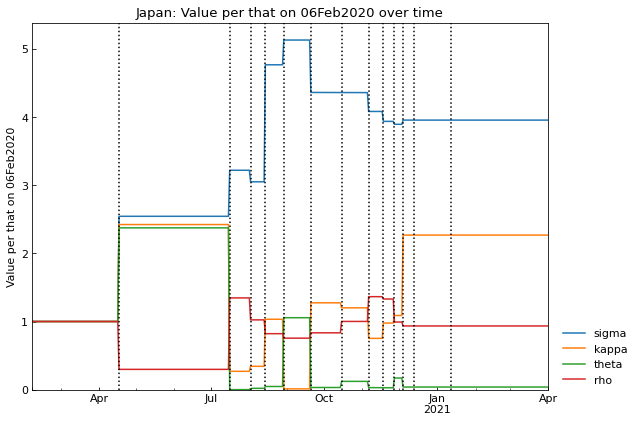

In [26]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [27]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 2nd phase (27Nov2020 - 03Dec2020): finished  223 trials in 0 min 10 sec


	 0th phase (17Apr2020 - 15Jul2020): finished 2846 trials in 3 min  0 sec

	 7th phase (16Jul2020 - 01Aug2020): finished 2959 trials in 3 min  1 sec

	10th phase (02Aug2020 - 13Aug2020): finished 2966 trials in 3 min  1 sec

	12th phase (06Feb2020 - 16Apr2020): finished 2888 trials in 3 min  1 sec

	 9th phase (29Aug2020 - 31Aug2020): finished  232 trials in 0 min 10 sec

	 8th phase (01Sep2020 - 19Sep2020): finished  464 trials in 0 min 20 sec

	 4th phase (06Nov2020 - 17Nov2020): finished  777 trials in 0 min 30 sec

	11th phase (04Dec2020 - 12Dec2020): finished 1718 trials in 1 min 20 sec

	 5th phase (14Aug2020 - 28Aug2020): finished 1205 trials in 0 min 50 sec

	 3rd phase (15Oct2020 - 05Nov2020): finished 3156 trials in 3 min  0 sec

	 1st phase (18Nov2020 - 26Nov2020): finished 3226 trials in 3 min  0 sec

	 6th phase (20Sep2020 - 14Oct2020): finished 3263 trials in 3 min  0 sec

Completed optimization. Total: 6 min 52 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 5th phase (01Sep2020 - 12Dec2020): finished 10552 trials in 3 min  0 sec

Completed optimization. Total: 3 min  0 sec


In [28]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.62  0.018973  0.000151   
              1st    17Apr2020  15Jul2020  SIR-F  0.53  0.045027  0.000366   
              2nd    16Jul2020  01Aug2020  SIR-F  2.03  0.000019  0.000041   
              3rd    02Aug2020  13Aug2020  SIR-F  1.63  0.000381  0.000052   
              4th    14Aug2020  28Aug2020  SIR-F  0.83  0.000896  0.000156   
              5th    29Aug2020  31Aug2020  SIR-F  0.98  0.005474  0.000093   
              6th    01Sep2020  19Sep2020  SIR-F  0.73  0.000655  0.000284   
              7th    20Sep2020  14Oct2020  SIR-F  0.92  0.000614  0.000192   
              8th    15Oct2020  05Nov2020  SIR-F  1.11  0.002317  0.000181   
              9th    06Nov2020  17Nov2020  SIR-F  1.62  0.000590  0.000114   
              10th   18Nov2020  26Nov2020  SIR-F  1.63  0.000529  0.000148   
              11th   27Nov2020  03Dec2020  SIR-F  1.23  0.003250  0.000164   
              12th   04Dec2020  12Dec2020  SIR-F  1.13  0.000736  0.000342   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.62  0.018973  0.000151   
              1st    17Apr2020  15Jul2020  SIR-F  0.53  0.045027  0.000366   
              2nd    16Jul2020  01Aug2020  SIR-F  2.03  0.000019  0.000041   
              3rd    02Aug2020  13Aug2020  SIR-F  1.63  0.000381  0.000052   
              4th    14Aug2020  28Aug2020  SIR-F  0.83  0.000896  0.000156   
              5th    29Aug2020  31Aug2020  SIR-F  0.98  0.005474  0.000093   
              6th    01Sep2020  12Dec2020  SIR-F  0.98  0.005474  0.000093   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.020557  0.004215  0.259382    2888  3 min  1 sec  
              1st    0.006130  0.010719  0.354283    2846  3 min  0 sec  
              2nd    0.027674  0.013565  0.025835    2959  3 min  1 sec  
              3rd    0.021052  0.012852  0.040035    2966  3 min  1 sec  
              4th    0.016886  0.020085  0.015634    1205  0 min 50 sec  
              5th    0.015483  0.015566  0.002124     232  0 min 10 sec  
              6th    0.015857  0.021544  0.034396     464  0 min 20 sec  
              7th    0.017143  0.018375  0.024500    3263  3 min  0 sec  
              8th    0.020578  0.018365  0.028790    3156  3 min  0 sec  
              9th    0.028042  0.017200  0.009464     777  0 min 30 sec  
              10th   0.027339  0.016587  0.020375    3226  3 min  0 sec  
              11th   0.020397  0.016407  0.012188     223  0 min 10 sec  
              12th   0.019216  0.016666  0.008454    1718  1 min 20 sec  
Retrospective 0th    0.020557  0.004215  0.259382    2888  3 min  1 sec  
              1st    0.006130  0.010719  0.354283    2846  3 min  0 sec  
              2nd    0.027674  0.013565  0.025835    2959  3 min  1 sec  
              3rd    0.021052  0.012852  0.040035    2966  3 min  1 sec  
              4th    0.016886  0.020085  0.015634    1205  0 min 50 sec  
              5th    0.015483  0.015566  0.002124     232  0 min 10 sec  
              6th    0.015483  0.015566  0.321363   10552  3 min  0 sec

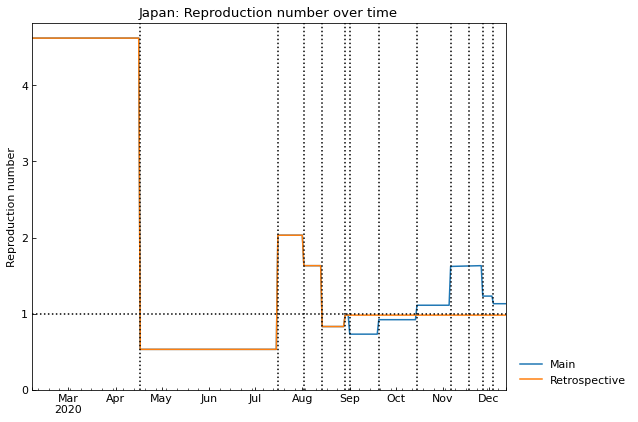

In [29]:
# History of reproduction number
_ = snl_retro.history("Rt")

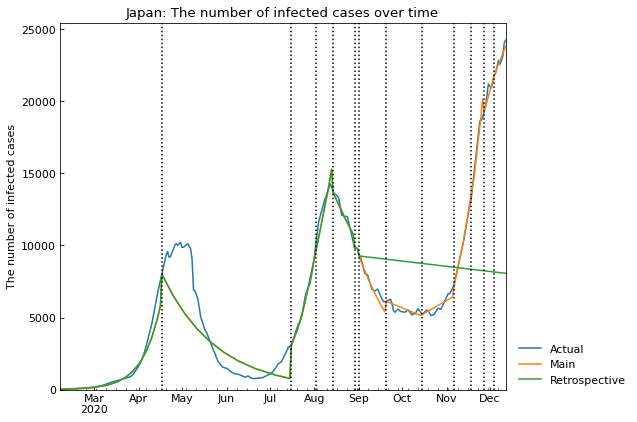

In [30]:
# History of Infected
_ = snl_retro.history("Infected")

In [31]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 13Dec2020,Infected on 13Dec2020,Fatal on 13Dec2020,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,24053,13Dec2020,175023,24053,2608,0.73,0.92,1.11,1.62,1.63,1.23,1.13
Retrospective,15284,13Aug2020,137329,8055,2088,0.98,-,-,-,-,-,-
